# Imports

In [1]:
import os
from os.path import join as jp
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set();
from tqdm import tqdm_notebook as tqdm
from statsmodels.stats.descriptivestats import sign_test

from dpipe.io import load
from damri.utils import choose_root

In [2]:
meta = pd.read_csv('/gpfs/gpfs0/b.shirokikh/data/cc359/meta.csv', index_col='id')
meta.head()

,MRI,brain_mask,fold,tomograph_model,tesla_value,x,y,z
id,,,,,,,,
CC0030,images/CC0030_philips_15_42_F.nii.gz,masks/CC0030_philips_15_42_F_ss.nii.gz,4,philips,15,1.000008,0.888889,0.888889
CC0326,images/CC0326_ge_3_55_M.nii.gz,masks/CC0326_ge_3_55_M_ss.nii.gz,3,ge,3,1.000000,1.000000,1.000000
CC0187,images/CC0187_siemens_3_63_F.nii.gz,masks/CC0187_siemens_3_63_F_ss.nii.gz,1,siemens,3,1.329996,1.000000,1.000000
CC0114,images/CC0114_philips_3_60_M.nii.gz,masks/CC0114_philips_3_60_M_ss.nii.gz,5,philips,3,1.000000,1.000000,1.000000
CC0231,images/CC0231_siemens_3_56_M.nii.gz,masks/CC0231_siemens_3_56_M_ss.nii.gz,1,siemens,3,1.330005,1.000000,1.000000


### Choosing experiment & bins:

In [ ]:
exp_oracle = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_base/cc359_unet2d_oracle'
exp_base = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_base/cc359_unet2d_one2all'

exp_stack_path = '/gpfs/gpfs0/b.shirokikh/experiments/da/paper_exp/unet2d/'
n2folder = {'1/48': '1_48', '1/36': '1_36', '1/24': '1_24', '1/12': '1_12', '1/6': '1_6', '1/3': '1_3',
            '1': '1', '3': '3'}

In [3]:
exp_oracle = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_base/cc359_vanilla_unet_oracle'
exp_base = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_base/cc359_vanilla_unet_one2all'

exp_stack_path = '/gpfs/gpfs0/b.shirokikh/experiments/da/paper_exp/vanilla_unet/'
n2folder = {'1/48': '1_48', '1/36': '1_36', '1/24': '1_24', '1/12': '1_12', '1/6': '1_6', '1/3': '1_3',
            '1': '1', '3': '3'}

In [ ]:
exp_oracle = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_augm/cc359_vanilla_unet_oracle'
exp_base = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_augm/cc359_vanilla_unet_one2all'

exp_stack_path = '/gpfs/gpfs0/b.shirokikh/experiments/da/paper_exp/augm_vanilla_unet/'
n2folder = {'1/48': '1_48', '1/36': '1_36', '1/24': '1_24', '1/12': '1_12', '1/6': '1_6', '1/3': '1_3',
            '1': '1', '3': '3'}

In [ ]:
exp_oracle = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_augm/cc359_unet2d_oracle'
exp_base = '/gpfs/gpfs0/b.shirokikh/experiments/da/dart_augm/cc359_unet2d_one2all'

exp_stack_path = '/gpfs/gpfs0/b.shirokikh/experiments/da/paper_exp/augm_unet2d/'
n2folder = {'1/48': '1_48', '1/36': '1_36', '1/24': '1_24', '1/12': '1_12', '1/6': '1_6', '1/3': '1_3',
            '1': '1', '3': '3'}

# Real shit happening

In [4]:
groups = list(n2folder.keys())

exps = ['posttrain', 'unfreeze_first', 'unfreeze_last']
exp2label = {e: l for e, l in zip(exps, ['All Layers', 'First Layers', 'Last Layers'])}
exp2color = {e: c for e, c in zip(exps, ['#ffbf00', '#e83f6f', '#2274a5'])}

In [5]:
def load_dice_stack_base(exp_path, n):
    stack = []
    for i in range(6):
        dices = load(jp(exp_path, f'experiment_{i}', 'test_metrics', 'sdice_score.json'))
        for j, f in enumerate(list(set(range(6)) - {i})):
            f_ids = sorted(list(load(
                jp(exp_stack_path, n2folder[n], 'posttrain',
                   f'experiment_{i*5+j}', 'test_metrics', 'sdice_score.json')
            ).keys()))
            stack.append(np.array([dices[_id] for _id in f_ids]))
    return stack

d_base = {n: {e: load_dice_stack_base(exp_base, n) for e in exps} for n in groups}

In [6]:
def load_dice_stack_oracle(exp_path, n):
    stack = []
    for i, i_cv in enumerate([i for f in range(6) for i in set(range(6)) - {f}]):
        dices = {}
        for j in range(3):
            dices = {**dices, **load(jp(exp_path, f'experiment_{i_cv*3+j}', 'test_metrics', 'sdice_score.json'))}
        f_ids = sorted(list(load(
                    jp(exp_stack_path, n2folder[n], 'posttrain',
                       f'experiment_{i}', 'test_metrics', 'sdice_score.json')
                ).keys()))
        stack.append(np.array([dices[_id] for _id in f_ids]))
    return stack

d_oracle = {n: {e: load_dice_stack_oracle(exp_oracle, n) for e in exps} for n in groups}

In [7]:
def load_dice_stack(exp_path):
    stack = []
    for i in range(30):
        dices = load(jp(exp_path, f'experiment_{i}', 'test_metrics', 'sdice_score.json'))
        stack.append(np.array([dices[_id] for _id in sorted(list(dices.keys()))]))
    return stack

d = {n: {e: load_dice_stack(jp(exp_stack_path, n2folder[n], e)) for e in exps} for n in groups}

In [8]:
d_means = {n: {e: [np.mean(arr) for arr in d[n][e]] for e in exps} for n in groups}
d_base_means = {n: {e: [np.mean(arr) for arr in d_base[n][e]] for e in exps} for n in groups}
d_oracle_means = {n: {e: [np.mean(arr) for arr in d_oracle[n][e]] for e in exps} for n in groups}

In [9]:
d_rel = {n: 
            {e: 
                [(s1 - s2) / (s3 - s2) for s1, s2, s3 in 
                 zip(d[n][e], d_base[n][e], d_oracle[n][e])]
                for e in exps
            }
            for n in groups
        }

In [10]:
d_rel_means = {n: 
            {e: 
                [(s1 - s2) / (s3 - s2) for s1, s2, s3 in 
                 zip(d_means[n][e], d_base_means[n][e], d_oracle_means[n][e])]
                for e in exps
            }
            for n in groups
        }

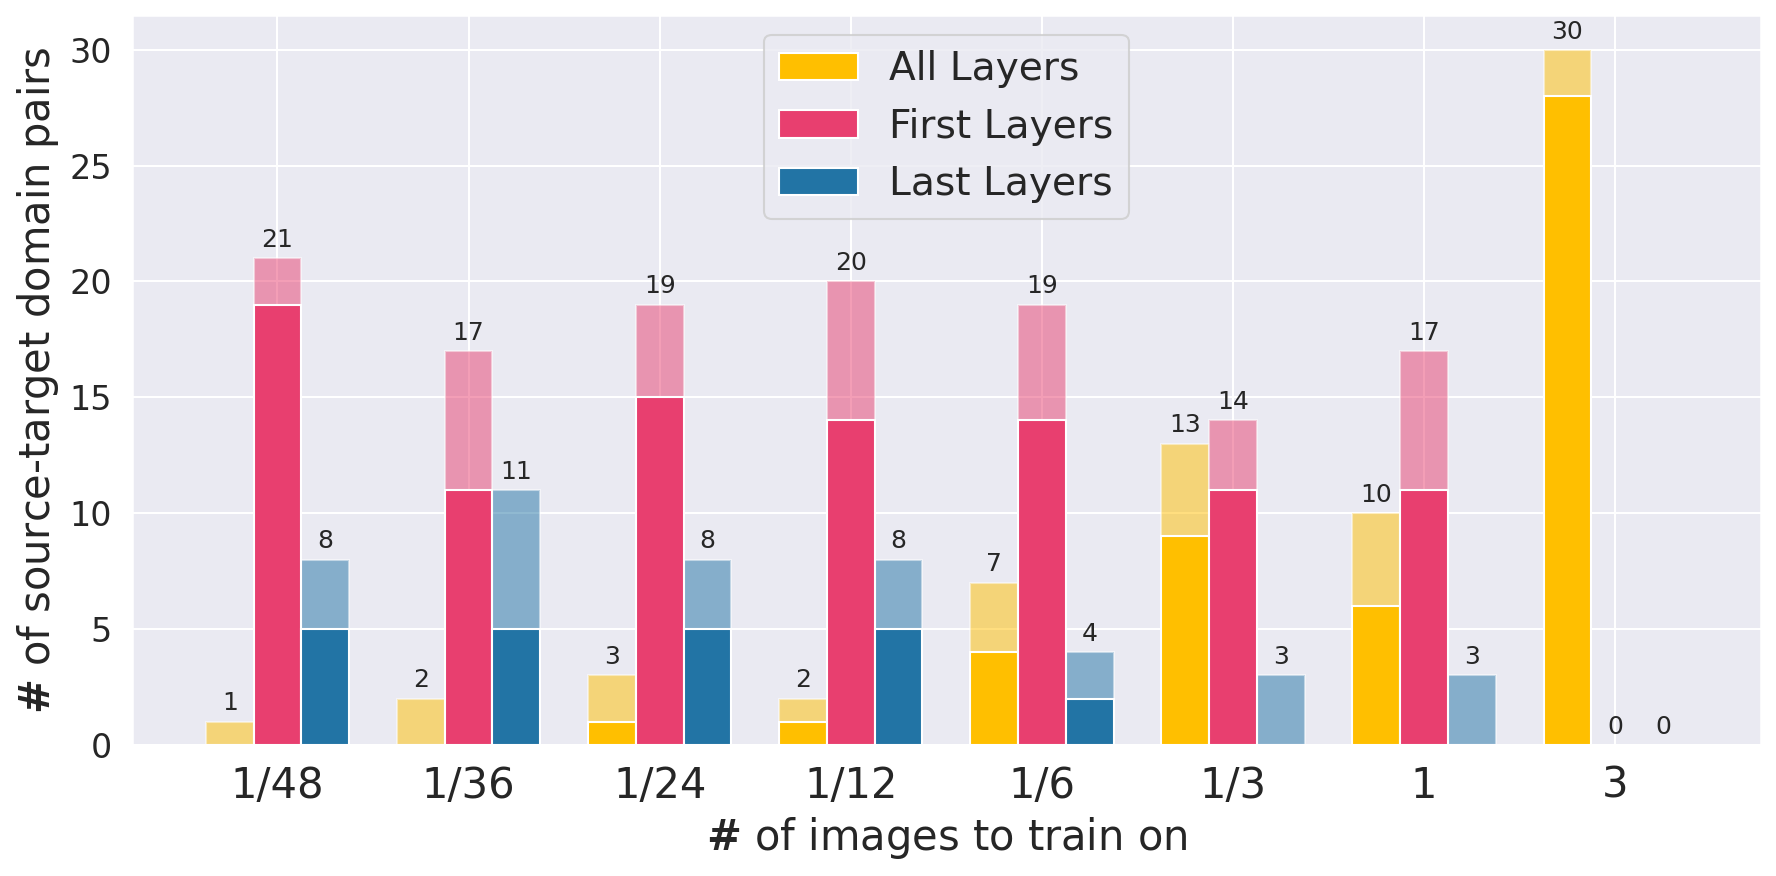

In [11]:
from collections import defaultdict
groups = list(d.keys())
xs = np.arange(len(d))

n_winners = defaultdict(list)
n_winners_strong, p_th = defaultdict(list), 0.1
for n in groups:
    for e in exps:
        n_winners[e].append(0)
        n_winners_strong[e].append(0)
    for i_exp, values in enumerate(zip(*[d_rel_means[n][e] for e in exps])):
        srt_idx = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
        n_winners[exps[srt_idx[0]]][-1] += 1
        arr = d_rel[n][exps[srt_idx[0]]][i_exp] - d_rel[n][exps[srt_idx[1]]][i_exp]
        if sign_test(arr)[-1] < p_th:
            n_winners_strong[exps[srt_idx[0]]][-1] += 1

w = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
rects = [ax.bar(xs + (i - 1) * w, n_winners[e], width=w, color=exp2color[e], alpha=0.5)
         for i, e in enumerate(exps)]
rects_p = [ax.bar(xs + (i - 1) * w, n_winners_strong[e], width=w, color=exp2color[e], label=exp2label[e])
           for i, e in enumerate(exps)]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\mathbf{\#}$ of source-target domain pairs', fontsize=20)
ax.set_xlabel('$\mathbf{\#}$ of images to train on', fontsize=20)
ax.set_xticks(xs)
ax.set_xticklabels(groups, fontsize=20)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='upper center', fontsize=18.8)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


for rect in rects:
    autolabel(rect)

fig.tight_layout()

plt.show()

In [12]:
df_to_vis = []
i = 0
for n in groups:
    sdict = d_rel_means[n]
    for e in exps:
        arr = sdict[e]
        for a in arr:
            df_to_vis.append({'id': i, 'n_data': n, 'gap_closed': a, 'exp': exp2label[e]})
            i += 1
df_to_vis = pd.DataFrame.from_records(df_to_vis, index='id')

y-lim is optional; choose the best one manually!

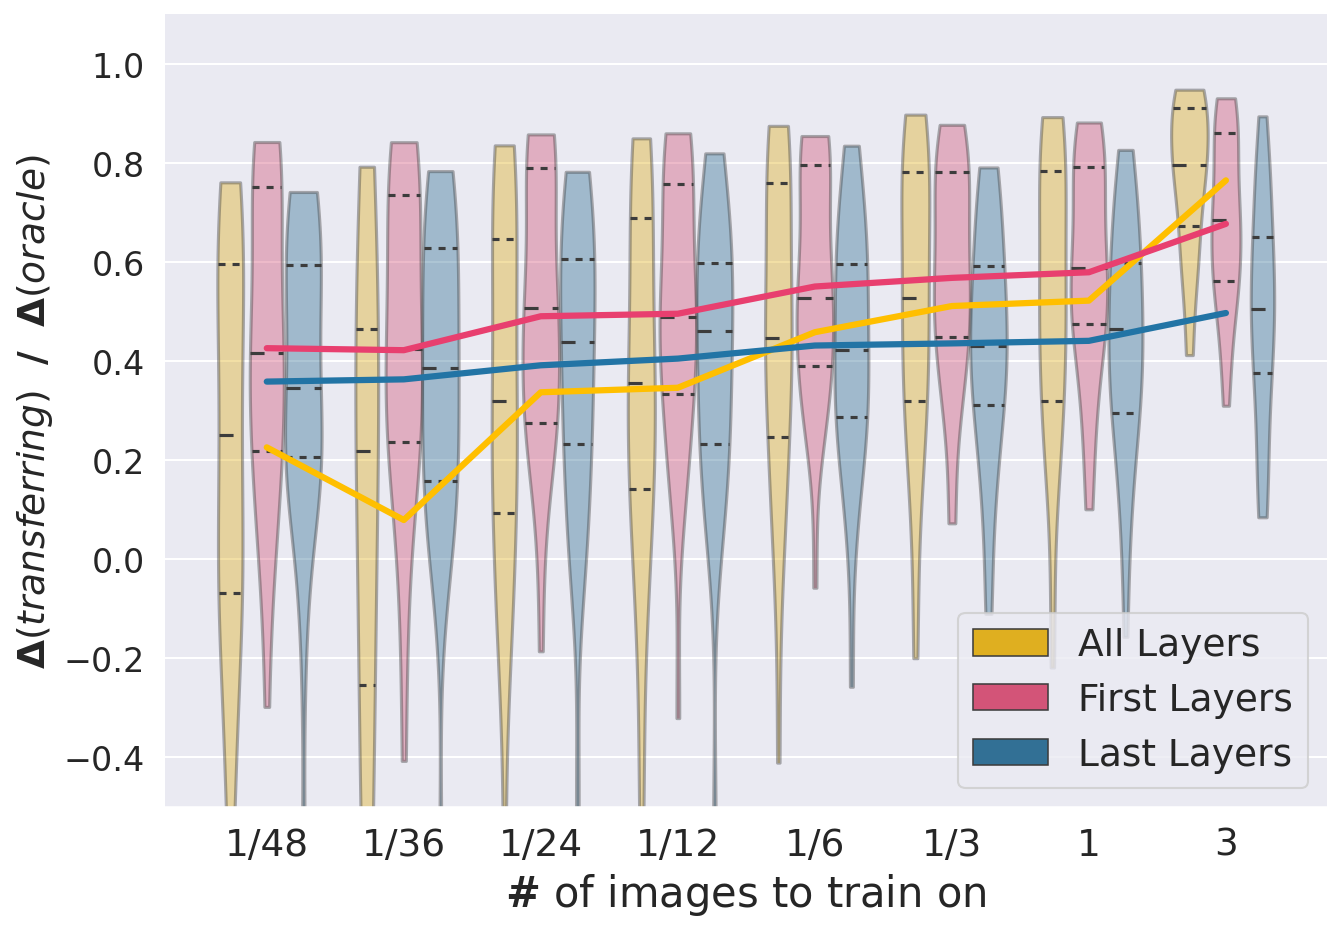

In [13]:
# sns.set(style="whitegrid", palette="pastel", color_codes=True);
sns.set(palette="pastel", color_codes=True);

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)

sns.violinplot(x='n_data', y='gap_closed', hue='exp', inner='quart', data=df_to_vis, cut=0,
               palette={e: c for e, c in zip(exp2label.values(), exp2color.values())})
sns.despine(left=True)

plt.setp(ax.collections, alpha=.4)

plt.ylim((-0.5, 1.1))

plt.legend(loc='lower right', fontsize=18)

# plt.ylabel('delta (transfering) / delta (oracle)', fontsize=18)
ax = plt.gca()
ax.set_ylabel('$\mathbf{\Delta} (transferring) \ \ \mathbf{/} \ \ \mathbf{\Delta} (oracle)$', fontsize=18)

# plt.xlabel('# of images to train on', fontsize=20)
ax.set_xlabel('$\mathbf{\#}$ of images to train on', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

for e in exps:
    arr = np.array([np.mean(d_rel_means[n][e]) for n in list(d.keys())])
    plt.plot(np.arange(len(d)), arr, color=exp2color[e], linewidth=3)
    
# plt.xticks(ticks=np.arange(len(d)), labels=list(n2folder.keys()))


plt.show()